In [2]:
from libraries.DES import *
from libraries.theoretical_results import *
import matplotlib.pyplot as plt
import numpy as np


In [3]:
def run_simulations(
    rho_steps,
    num_samples,
    num_servers,
    policy,
    queuetype="MM",
    rho_range=(0.1, 1),
    mu=1,
):
    """Runs the simulation for a given number of steps and samples

    Args:
        steps (int): Number of steps
        num_samples (int): Number of samples
        num_servers (int): Number of servers
        policy (str): Scheduling policy
        queuetype (str, optional): Type of queue. Defaults to "MM". Options are "MM", "MD", "MC".
        rho_range (tuple, optional): Range of rho. Defaults to (0.1,1).
        mu (int, optional): Service rate. Defaults to 1.

    Returns:
        list: Average wait times
        list: Standard deviations
        list: System loads
        list: Service rates
        list: Arrival rates
    """
    # Initialize lists
    rho_list = []
    mu_list = []
    lamda_list = []
    averages_of_average_wait_times = []
    std_devs = []

    for rho in np.linspace(rho_range[0], rho_range[1], rho_steps):
        # Calculate lambda
        mu = mu
        lamda = rho * mu * num_servers
        # Run simulation for num_samples
        average_wait_times = []
        until = average_waiting_time_mmn(lamda, mu, num_servers)
        for _ in range(num_samples):
            wait_times = []
            env = simpy.Environment()
            env.process(
                run_server(
                    env, num_servers, lamda, mu, wait_times, policy, queuetype=queuetype
                )
            )
            env.run(until=min(until * 200, 20000))
            average_wait = get_average_wait_time(wait_times[-80:])
            average_wait_times.append(average_wait)
        # Append results to lists
        rho_list.append(rho)
        mu_list.append(mu)
        lamda_list.append(lamda)

        averages_of_average_wait_times.append(statistics.mean(average_wait_times))
        std_devs.append(np.std(average_wait_times))

    return averages_of_average_wait_times, std_devs, rho_list, mu_list, lamda_list

# 2) Write a DES program to verify the theoretical results with simulations for n=1,n=2,n=4.

Below we plot the results for n=1, n=2 and n=4. We compare them to the theoretical result for values of $\rho$ ranging from 0.85 to 0.999.


In [63]:
rho_range = (0.9, 0.999)
num_rho_steps = 10
num_sims = 60
full_data_subq2 = []
for n, rho_range in zip([1, 2, 4], [rho_range, (0.95, 0.999), (0.95, 0.999)]):
    data = run_simulations(num_rho_steps, num_sims, n, "FIFO", rho_range=rho_range)
    full_data_subq2.append(data)

In [72]:
def plot_compare_theory_vs_sim(n, rho_range, data):
    """Plots the theoretical results against the simulation results

    Args:
        n (int): Number of servers
        rho_range (tuple): Range of rho
        data (list): Data from the simulation

    Returns:
        None
    """
    averages_of_average_wait_times, std, rho_list, mu_list, lamda_list = data
    exact_rhos = np.linspace(rho_range[0], rho_range[1], 500)
    exact_wait_times = average_waiting_time_mmn(exact_rhos * n, 1, n)
    plt.title(f"Average waiting time for M/M/{n} queue compared with simulation")
    plt.errorbar(
        rho_list,
        averages_of_average_wait_times,
        yerr=std / np.sqrt(num_sims),
        fmt="o",
        label="Simulation and SEM",
    )
    plt.plot(exact_rhos, exact_wait_times + 1, label="theoretical")
    plt.xlabel(r"$\rho$ (system load)")
    plt.ylabel("Average waiting time (arbitrary units)")
    # plt.ylim(-1,max(averages_of_average_wait_times)+max(std/np.sqrt(num_sims))+5)
    plt.legend()
    plt.show()

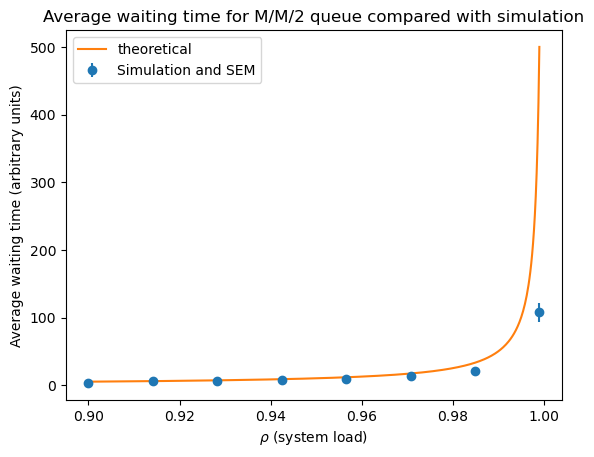

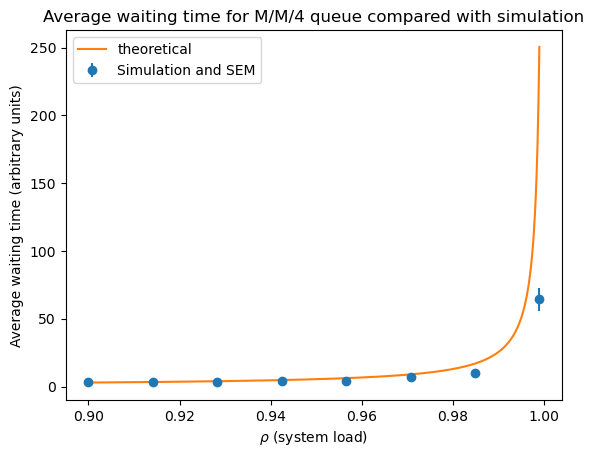

In [73]:
for i, n in enumerate([1, 2, 4]):
    plot_compare_theory_vs_sim(n, rho_range, data=full_data_subq2[i])

# 3) Compare the results to that for an M/M/1 queue with SJF.

In the next part we compare SJF to FIFO

In [8]:
rho_range = (0.9, 0.999)
num_rho_steps = 10
num_sims = 100
full_data_subq3 = []
n = 1
for policy in ["FIFO", "SJF"]:
    data = run_simulations(num_rho_steps, num_sims, n, policy, rho_range=rho_range)
    full_data_subq3.append(data)


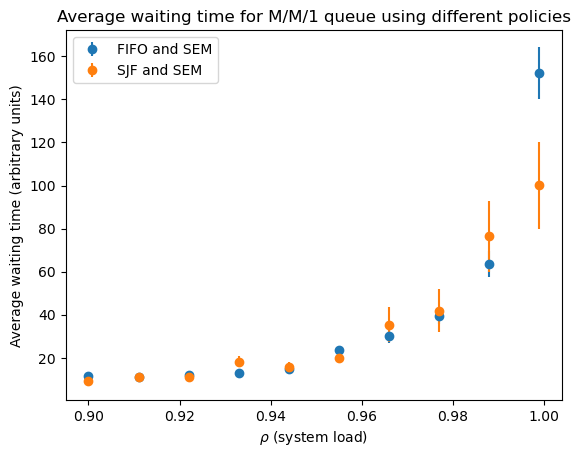

In [12]:
def plot_data(policy, data):
    """Plots the theoretical results against the simulation results

    Args:
        n (int): Number of servers
        rho_range (tuple): Range of rho
        data (list): Data from the simulation

    Returns:
        None
    """
    averages_of_average_wait_times, std, rho_list, mu_list, lamda_list = data

    plt.errorbar(
        rho_list,
        averages_of_average_wait_times,
        yerr=std / np.sqrt(num_sims),
        fmt="o",
        label=f"{policy} and SEM",
    )

    plt.xlabel(r"$\rho$ (system load)")
    plt.ylabel("Average waiting time (arbitrary units)")


def plot_subquestion_3(full_data):
    plt.title("Average waiting time for M/M/1 queue using different policies")
    for i, policy in enumerate(["FIFO", "SJF"]):
        plot_data(policy, data=full_data[i])
    plt.xlabel(r"$\rho$ (system load)")
    plt.ylabel("Average waiting time (arbitrary units)")
    # plt.ylim(-1,max(averages_of_average_wait_times)+max(std/np.sqrt(num_sims))+5)
    plt.legend()
    plt.show()


plot_subquestion_3(full_data)

# 4) Compare different service rate distributions for M/./1 queues.
In this part we compare the different service rate distributions

In [29]:
rho_range = (0.7, 0.999)
num_rho_steps = 10
num_sims = 100
policy = 'FIFO'
full_data_subq4 = []
n = 1
for queuetype in ["MM", "MD", "MC"]:
    data = run_simulations(num_rho_steps, num_sims, n, policy=policy, queuetype=queuetype, rho_range=rho_range,mu=1/0.8)
    full_data_subq4.append(data)


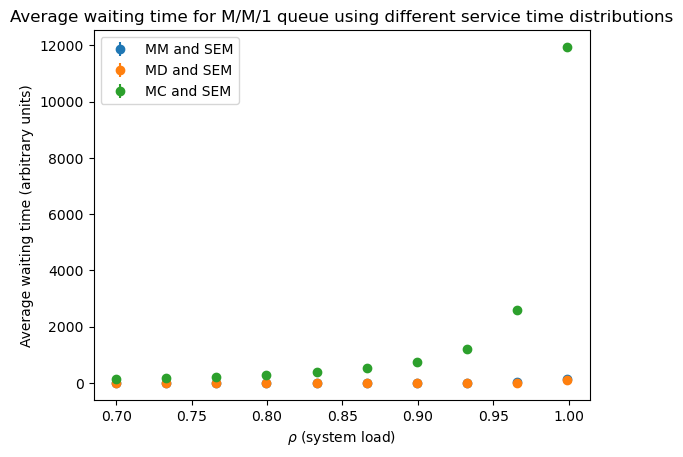

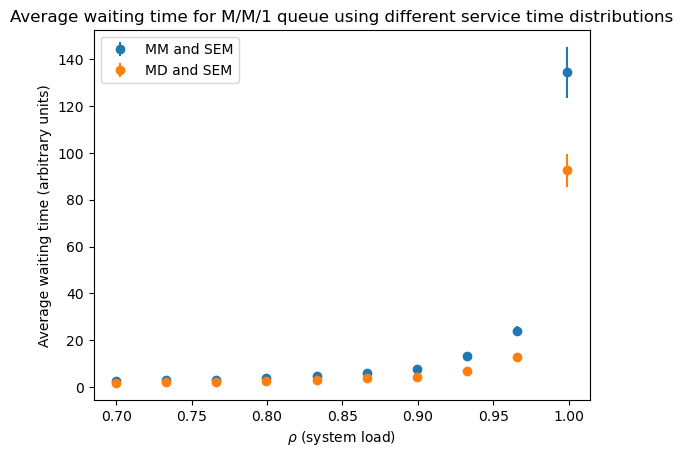

In [30]:
def plot_data_subq4(queuetype, data):
    """Plots the theoretical results against the simulation results

    Args:
        n (int): Number of servers
        rho_range (tuple): Range of rho
        data (list): Data from the simulation

    Returns:
        None
    """
    averages_of_average_wait_times, std, rho_list, mu_list, lamda_list = data

    plt.errorbar(
        rho_list,
        averages_of_average_wait_times,
        yerr=std / np.sqrt(num_sims),
        fmt="o",
        label=f"{queuetype} and SEM",
    )

    plt.xlabel(r"$\rho$ (system load)")
    plt.ylabel("Average waiting time (arbitrary units)")


def plot_subquestion_4(full_data):
    plt.title("Average waiting time for M/M/1 queue using different service time distributions")
    for i, (queuetype,_) in enumerate(zip(["MM", "MD", "MC"],range(len(full_data)))):
        plot_data_subq4(queuetype, data=full_data[i])
    
    plt.xlabel(r"$\rho$ (system load)")
    plt.ylabel("Average waiting time (arbitrary units)")
    plt.legend()
    plt.show()

plot_subquestion_4(full_data_subq4)
plot_subquestion_4(full_data_subq4[0:2])